In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import sys
# insert at 1, 0 is the script path (or '' in REPL)
# sys.path.append( '/home/tianfuwang/pytorch3d-deflectometry-tianfu')

%load_ext autoreload
%autoreload 2
%matplotlib inline
#%reset

from ipywidgets import interactive, interact

import os
import torch
import numpy as np
from tqdm import tqdm_notebook
import imageio
from skimage import img_as_ubyte
import scipy.spatial as sp
from scipy.ndimage import gaussian_filter
# from utils import image_grid, plot_camera_scene
import matplotlib.pyplot as plt
import scipy.io

from pytorch3d.renderer.cameras import SfMPerspectiveCameras
from pytorch3d.renderer import look_at_view_transform

from pytorch3d.transforms import Rotate, Translate, Scale, Transform3d, so3_log_map, so3_exponential_map, euler_angles_to_matrix,matrix_to_euler_angles

torch.cuda.empty_cache()

import Tianfu_MultiviewDeflectometryModel as T_DM;
from pytorch3d.io import load_objs_as_meshes, load_obj
from pytorch3d.structures import Meshes, Textures
torch.cuda.device_count()

device = torch.cuda.current_device()
dtype = torch.float32

# Set the cuda device 
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)
else:
    device = torch.device("cpu")
# torch.cuda.set_device(device)
dtype = torch.float32
print(device)

cuda:0


/home/jiwon/miniconda3/envs/eye_model/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/jiwon/miniconda3/envs/eye_model/lib/python3.8/site-packages/torchvision/image.so: undefined symbol: _ZNK3c107SymBool10guard_boolEPKcl'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
!nvidia-smi

Fri Mar 22 02:40:04 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:2B:00.0  On |                  N/A |
| 80%   34C    P5    99W / 420W |    814MiB / 24576MiB |     21%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Load Face Mesh

In [3]:
from pytorch3d.io import load_objs_as_meshes, load_obj
from pytorch3d.structures import Meshes, Textures
from pytorch3d.renderer import (
    look_at_view_transform,
    OpenGLPerspectiveCameras, 
    PointLights, 
    DirectionalLights, 
    Materials, 
    RasterizationSettings, 
    MeshRenderer, 
    MeshRasterizer,  
    TexturedSoftPhongShader
)

face_mesh = None

In [4]:
import Tianfu_MultiviewDeflectometryModel as T_DM;
from pytorch3d.io import load_objs_as_meshes, load_obj
from pytorch3d.structures import Meshes, Textures

obj_filename = "./mesh_data/Textured_Eye_Model/Eye_Model.obj"
cm = 0.01   
mesh = load_objs_as_meshes([obj_filename], device=device)
verts, faces, aux = load_obj(obj_filename, device = device)

tex_maps = aux.texture_images
if tex_maps is not None and len(tex_maps) > 0:
    verts_uvs = aux.verts_uvs[None, ...].to(device)  # (1, V, 2)
    faces_uvs = faces.textures_idx[None, ...].to(device)  # (1, F, 3)
    image = list(tex_maps.values())[0].to(device)[None]
    print(faces_uvs.shape)
    print(verts_uvs.shape)
    mesh_texture = Textures(verts_uvs=verts_uvs, faces_uvs=faces_uvs, maps=image)
    print(image.shape)

torch.Size([1, 37122, 3])
torch.Size([1, 18822, 2])
torch.Size([1, 1024, 1024, 3])


In [5]:
# create the camera views
cm = 0.01 
views1D = 2;
views = 2
cam_dist = 7 * cm; # the distance to the camera
max_ang = 10;
ang = np.linspace(-max_ang,max_ang,views1D) # grid of angles in degrees
if views ==1:
    ang = 0;
azim,elev = np.meshgrid(ang, ang);
azim = np.append(azim, 0)
elev = np.append(elev, 0)

# create torch tensors
dist = cam_dist*torch.ones(views , dtype=dtype).view(views ,1)   # distance from camera to the object

#camera elevation
elev = torch.tensor([0,0], dtype=dtype).view(views,1)

#camera azimuth
azim = torch.tensor([0,0], dtype=dtype).view(views,1)

# Get the position of the camera based on the spherical angles
cR, cT = look_at_view_transform(dist, elev, azim, device=device) # (views,3,3), (views,3) 
# print(cR, cT)
# print(torch.matmul(cam_rot.inverse(), cR[0]))
cR[1][0, 0] = 1
cR[1][2, 2] = 1



cT[0] = cT[1]
cR[0] = cR[1]


In [6]:
corners = torch.tensor(scipy.io.loadmat("./cam_data/corners.mat")["corners"], dtype=dtype).to(device)  *0.001


corners3 = (corners[2] - corners[0]) + corners[1]
torch.dot(corners3 - corners[1], corners3 - corners[2])
corners  = torch.cat((corners, corners3[None]), dim = 0)
print(corners)
corners[:, 2] -= 0.07
corners[:, 1] *= -1

corners[:, 0] *= -1
print(corners)
corners2 = corners.clone()
corners2[0] = corners[1]
corners2[1] = corners[0]
corners2[2] = corners[3]
corners2[3] = corners[2]
corners = corners2

tensor([[-0.0691, -0.0802,  0.0275],
        [ 0.0703, -0.0871,  0.0191],
        [-0.0675, -0.0194,  0.0058],
        [ 0.0719, -0.0262, -0.0026]], device='cuda:0')
tensor([[ 0.0691,  0.0802, -0.0425],
        [-0.0703,  0.0871, -0.0509],
        [ 0.0675,  0.0194, -0.0642],
        [-0.0719,  0.0262, -0.0726]], device='cuda:0')


In [7]:
screen_trans = corners.mean(axis = 0)
print(screen_trans)


y = (corners[2] - corners[0])

x = (corners[1] - corners[0])

print(x, y)
print(torch.sqrt(torch.sum(x * x)))
print(torch.sqrt(torch.sum(y * y)))

screen_size_x = 2 * torch.sqrt(torch.sum(x * x))
screen_size_y = 2 * torch.sqrt(torch.sum(y * y))
print(screen_size_x, screen_size_y)
x = x/torch.sqrt(torch.sum(x * x))
y = -y/torch.sqrt(torch.sum(y * y))
print(y)
z = torch.cross(x, y)
print("z")
print(z)
z = z / (torch.sqrt(torch.sum (z * z)))
print(z)
print(x, y,z)

screen_rot = torch.zeros((3,3), dtype = dtype, device = device)
screen_rot[:, 0] = x
screen_rot[:, 1] = y
screen_rot[:, 2] = z
print(screen_rot)

tensor([-0.0014,  0.0532, -0.0576], device='cuda:0')
tensor([ 0.1394, -0.0068,  0.0083], device='cuda:0') tensor([-0.0017, -0.0608, -0.0217], device='cuda:0')
tensor(0.1398, device='cuda:0')
tensor(0.0646, device='cuda:0')
tensor(0.2796, device='cuda:0') tensor(0.1292, device='cuda:0')
tensor([0.0260, 0.9415, 0.3359], device='cuda:0')
z
tensor([-0.0726, -0.3334,  0.9400], device='cuda:0')
tensor([-0.0726, -0.3334,  0.9400], device='cuda:0')
tensor([ 0.9970, -0.0488,  0.0597], device='cuda:0') tensor([0.0260, 0.9415, 0.3359], device='cuda:0') tensor([-0.0726, -0.3334,  0.9400], device='cuda:0')
tensor([[ 0.9970,  0.0260, -0.0726],
        [-0.0488,  0.9415, -0.3334],
        [ 0.0597,  0.3359,  0.9400]], device='cuda:0')


In [8]:
# If the camera to screen transform is identity, the screen textures map to [-1:1,-1:1,0] in camera coordinates
# the screen transform is defined relative to the camera coordinates
# relative transform is used so that screen transform is not optimized independently from camera
s2cT = torch.zeros((2,3) ,device=device, dtype=dtype)# translate the screen -1 in Y-axis relative to camera
s2cR = torch.zeros((2,3, 3) ,device=device, dtype=dtype)# rotation is fixed same as camera
sS = torch.tensor([1, 1, 1],device=device, dtype=dtype).expand(views,3) # scale maps screen coords to [-1:1,-1:1,0]

# print(s2cR)

# print()
s2cR[0] = screen_rot.clone()
s2cT[0] =  -torch.matmul(s2cR[0].inverse(), screen_trans.clone())

scale_factor = 1
screen_size_x = 0.1398* scale_factor
screen_size_y = 0.0646 * scale_factor


print(s2cR)

print(s2cT)
cameraToScreenTrans = Transform3d(device=device).compose(Rotate(s2cR, device=device)).translate(s2cT)
print(cameraToScreenTrans.get_matrix())



tensor([[[ 0.9970,  0.0260, -0.0726],
         [-0.0488,  0.9415, -0.3334],
         [ 0.0597,  0.3359,  0.9400]],

        [[ 0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000]]], device='cuda:0')
tensor([[ 0.0074, -0.0307,  0.0718],
        [ 0.0000,  0.0000,  0.0000]], device='cuda:0')
tensor([[[ 0.9970,  0.0260, -0.0726,  0.0000],
         [-0.0488,  0.9415, -0.3334,  0.0000],
         [ 0.0597,  0.3359,  0.9400,  0.0000],
         [ 0.0074, -0.0307,  0.0718,  1.0000]],

        [[ 0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  1.0000]]], device='cuda:0')


/home/jiwon/miniconda3/envs/eye_model/lib/python3.8/site-packages/pytorch3d/transforms/transform3d.py:706: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)


In [9]:
#Here's a function to convert parameters in a intrisic matrix K to pytorch3D intrinsics

def convert_intrinsic_matrix_to_intrinsic_params(fx, fy, px, py, imwidth, imheight):

  """
      for perspective camera, fx, fy, px, py correspond to following values in intrinic matrix
      K = [
                              [fx,   0,   px,   0],
                              [0,   fy,   py,   0],
                              [0,    0,    0,   1],
                              [0,    0,    1,   0],
      ]

      imwidth, imheight: width and height of camera image in pixels
  """


  half_imwidth = imwidth / 2.0
  half_imheight = imheight / 2.0
  fx = fx / half_imwidth
  fy = fy / half_imheight
  px = -(px - half_imwidth) / half_imwidth
  py = -(py - half_imheight) / half_imheight

  focal_length = [fx, fy]
  principal_point = [px, py]
  return focal_length, principal_point


In [10]:
fx_cam = [2651.74260529167, 2624.54733376980]
fy_cam = [2650.95006027965,2624.65009380545]
px_cam = [675.661710350754, 653.611361380318]
py_cam = [519.315006582873, 545.305253355869]

In [11]:
#camera intrinsics

render_res = 512
fx =2651.74260529167 /1328 * render_res
fy = 2650.95006027965 /1328 * render_res
px = 673.693748324135
py =  5.257529476491524e+02      
actual_imwidth = render_res
actual_imheight = render_res
half_actual_imwidth = actual_imwidth
half_actual_imheight = actual_imheight

render_size = max(actual_imwidth, actual_imheight)
half_render_size = render_size
render_px = px + (render_size - actual_imwidth)
render_py = py + (render_size - actual_imheight)//2
print(render_px, render_py)

  
Np = render_size

focal_length, principal_point = convert_intrinsic_matrix_to_intrinsic_params(fx, fy, render_px, render_py, render_size, render_size)
principal_point = [0,0]


fl = torch.zeros((2,2))

fl[0] = torch.tensor(focal_length)
pp = torch.tensor(principal_point).expand(views,2)
print("fl")
print(fl)

#camera intrinsics
#camera intrinsics
fx =2651.74260529167 /1328 * render_res
fy = 2650.95006027965 /1328 * render_res
px = 673.693748324135
py =  5.257529476491524e+02      
actual_imwidth = render_res
actual_imheight = render_res
half_actual_imwidth = actual_imwidth
half_actual_imheight = actual_imheight

render_size = max(actual_imwidth, actual_imheight)
half_render_size = render_size
render_px = px + (render_size - actual_imwidth)
render_py = py + (render_size - actual_imheight)//2
print(render_px, render_py)

  
Np = render_size

focal_length, principal_point = convert_intrinsic_matrix_to_intrinsic_params(fx, fy, render_px, render_py, render_size, render_size)
principal_point = [0,0]

print("focal_length")
print(focal_length)
# print(principal_point)

# print(focal_length, principal_point)


fl[1] = torch.tensor(focal_length)
pp = torch.tensor(principal_point).expand(views,2)
# print("fl")
# print(fl)

# #camera intrinsics
# fx = 2694.2//2
# fy = 2692.8//2
# px = 656.067589426400//2
# py =  535.489756013584 //2    
# actual_imwidth = 1328//2
# actual_imheight = 1048//2
# half_actual_imwidth = actual_imwidth//2
# half_actual_imheight = actual_imheight//2

# render_size = max(actual_imwidth, actual_imheight)
# half_render_size = render_size//2
# render_px = px + (render_size - actual_imwidth)
# render_py = py + (render_size - actual_imheight)//2
# print("render_size")

# print(render_size)
# # print(render_px, render_py)

  
# Np = render_size

# focal_length, principal_point = convert_intrinsic_matrix_to_intrinsic_params(fx, fy, render_px, render_py, render_size, render_size)
# principal_point = [0,0]
# print("focal_length")
# print(focal_length)



# fl[0] = torch.tensor(focal_length) 
# print(principal_point)
# pp = torch.tensor(principal_point).expand(views,2)

print(fl)
cameras = SfMPerspectiveCameras(focal_length= fl, principal_point= pp, R=cR, T=cT, device=device)

Np = render_size
print(Np)
# visualize the camera positions
# f = plot_camera_scene(cameras, cameras, "ground truth cameras")



673.693748324135 525.7529476491524
fl
tensor([[3.9936, 3.9924],
        [0.0000, 0.0000]])
673.693748324135 525.7529476491524
focal_length
[3.9935882609814306, 3.9923946690958587]
tensor([[3.9936, 3.9924],
        [3.9936, 3.9924]])
512


## Target Scene Translation and Rotation

In [12]:
torch.random.manual_seed(10)

# -0.0016, -0.0052,  0.0174
torch.random.manual_seed(30)
mesh_trans =  0.0 * cm *  torch.rand(3,device=device, dtype=dtype)
mesh_trans[0] =-0.004
mesh_trans[1] = -0.003
mesh_trans[2] =0.012
print(mesh_trans)
torch.random.manual_seed(30)
euler_angles =    -0.5 * (torch.rand(3,device=device, dtype=dtype))
euler_angles[0] =-11* np.pi/180
euler_angles[1] = 26* np.pi/180
euler_angles[2] = 0* np.pi/180
print(euler_angles * 180 /np.pi)
euler_type = "XYZ"
mesh_rotate = euler_angles_to_matrix(euler_angles, euler_type)
mesh_rotate = Rotate(R=mesh_rotate, device=device)

tensor([-0.0040, -0.0030,  0.0120], device='cuda:0')
tensor([-11.0000,  26.0000,   0.0000], device='cuda:0')


   ## Generate Shader Maps for Rendering

In [29]:
#For a purely specular reflection please use the following settings, 
#dif_map and amb_map should be 0, 
diff_map = 0*  torch.ones((1,1,3),device=device)
spec_map = 1 * torch.ones((1,1,3),device=device)
gamma_map = 10000*torch.ones((1,1,3),device=device)
amb_map = 0.0*  torch.ones((1,1,3),device=device)
shader_maps=dict({'diff_map':diff_map, 'spec_map':spec_map,'gamma_map':gamma_map, 'amb_map':amb_map})

In [30]:
from Tianfu_MultiviewDeflectometryModel import GenerateSphereSmoothVerts, GenerateSphereSmoothFaces
from pytorch3d.io import save_obj
latitudes = 100;
longitudes = 100;
delta_latitude = np.pi /latitudes;
delta_logitude = 2 * np.pi/longitudes;

verts = torch.zeros(((latitudes + 1) * (longitudes + 1), 3), dtype= dtype,device = device)


latitudeAngles = torch.linspace(np.pi/2, -np.pi/2, latitudes + 1, dtype= dtype,device = device)
z = 1.05 * torch.sin(latitudeAngles)[latitudes//2:]
xy = torch.sqrt(torch.max((0.75 ** 2 - (z + 0.3) **2), 1 - z* z  ) )
xy[-1] = 0
# start_index = 2
# end_index = 13
# xy[-end_index: -start_index + 1] = torch.linspace(xy[-end_index], xy[-start_index], end_index- start_index + 1)
verts = GenerateSphereSmoothVerts(xy = xy, z = z,  latitudes = latitudes, longitudes = longitudes)
faces = GenerateSphereSmoothFaces(latitudes = latitudes, longitudes = longitudes)
mesh = Meshes(verts=[verts], faces=[faces], textures=mesh_texture)
save_obj("./dl_data_set_12_20/meshes/00.obj", verts, faces)

In [31]:
from Tianfu_MultiviewDeflectometryModel import GenerateSphereSmoothVerts, GenerateSphereSmoothFaces
from pytorch3d.io import save_obj
latitudes = 100;
longitudes = 100;
delta_latitude = np.pi /latitudes;
delta_logitude = 2 * np.pi/longitudes;

verts = torch.zeros(((latitudes + 1) * (longitudes + 1), 3), dtype= dtype,device = device)


latitudeAngles = torch.linspace(np.pi/2, -np.pi/2, latitudes + 1, dtype= dtype,device = device)
z = 1.05 * torch.sin(latitudeAngles)[latitudes//2:]
xy = torch.sqrt(torch.max((0.7 ** 2 - (z + 0.35) **2), 1 - z* z  ) )
xy[-1] = 0
start_index = 4
end_index = 30
xy[-end_index: -start_index + 1] = torch.linspace(xy[-end_index], xy[-start_index], end_index- start_index + 1)
verts = GenerateSphereSmoothVerts(xy = xy, z = z,  latitudes = latitudes, longitudes = longitudes)
faces = GenerateSphereSmoothFaces(latitudes = latitudes, longitudes = longitudes)
mesh = Meshes(verts=[verts], faces=[faces], textures=mesh_texture)
save_obj("./dl_data_set_12_20/meshes/02.obj", verts, faces)

## Initialize Measurement Model

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


cam_to_Screen
tensor([[[ 0.9970,  0.0260, -0.0726,  0.0000],
         [-0.0488,  0.9415, -0.3334,  0.0000],
         [ 0.0597,  0.3359,  0.9400,  0.0000],
         [ 0.0074, -0.0307,  0.0718,  1.0000]],

        [[ 0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  1.0000]]], device='cuda:0')
world_to_cam
tensor([[[1.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 1.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 1.0000, 0.0000],
         [0.0000, 0.0000, 0.0700, 1.0000]],

        [[1.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 1.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 1.0000, 0.0000],
         [0.0000, 0.0000, 0.0700, 1.0000]]], device='cuda:0')
world_to_screen
tensor([[[ 0.9970,  0.0260, -0.0726,  0.0000],
         [-0.0488,  0.9415, -0.3334,  0.0000],
         [ 0.0597,  0.3359,  0.9400,  0.0000],
         [ 0.0074, -0.0307,  0.0718,  1.0000]],

     

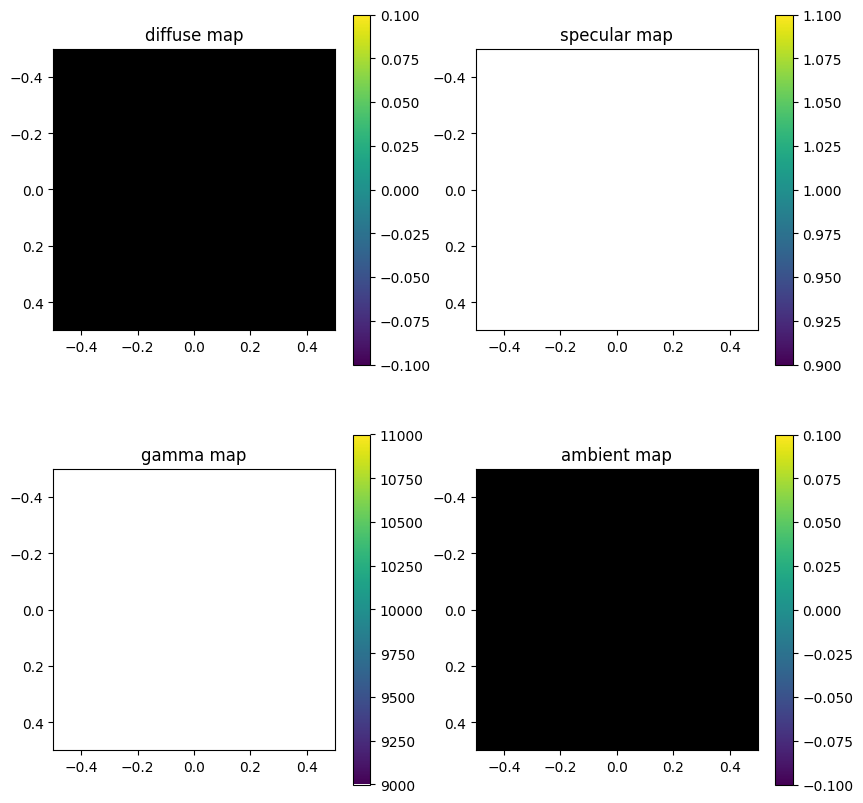

In [32]:
# Initialize a model using the renderer, mesh and reference image
opt_settings = dict({'opt_depth': False, 'opt_norm': False, 'opt_cam': False, 'opt_screen': False,
              'opt_diff':False, 'opt_spec':False, 'opt_gamma':False, 'opt_amb':False, 'opt_verts2d':False,
              'opt_mesh_transform': False, 'opt_pattern':False, 'opt_geom': False})                  
model_gt = T_DM.Tianfu_MultiviewDeflectometryModel(device=device,dtype=dtype, Np=Np, init_cam=cameras,
                                 cameraToScreenTransform=cameraToScreenTrans,
                                 shader_maps=shader_maps, opt_settings=opt_settings,
                                  face_mesh = face_mesh,
                                  mesh = mesh,
                                  mesh_rotate = mesh_rotate,
                                  mesh_translate = mesh_trans,
                                 screen_size_u = screen_size_x ,
                                 screen_size_v = screen_size_y ,
                                 imheight = actual_imheight, 
                                  imwidth = actual_imwidth).to(device)
model_gt.visualize_shader_maps()

## Generate Target Measurements

In [33]:
Nt_x = 1024; # number pixels across for tecture map 
Nt_y = 1024;
periods = np.array([[1, 1]]); # the tensor of periods
Nph = 4; # the number of phase shifts between [0,2*pi]
model_gt.create_sinusoid_reflection_maps(Nt = [Nt_x, Nt_y], Nph=Nph, periods=periods);
model_gt.pattern = model_gt.pattern

In [34]:
from PIL import Image
import skimage.transform
import cv2


tex_dir = './img_data/'
tex_imgs = ["cross.png", "cross_2.png"]

for img in tex_imgs:
    tex = imageio.imread(f"{tex_dir}/{img}")
    tex = np.asarray(tex)
    tex = skimage.transform.resize(tex, (Nt_y, Nt_x))
    tex = torch.tensor(tex, dtype= dtype, device = device)
    print(tex.shape, len(tex.shape))
    tex = tex[:,:,None].expand(-1,-1, 3)
    
    print(tex.shape)
    model_gt.pattern  = torch.cat((model_gt.pattern,tex.permute(2, 0,1)[None,]) )

model_gt.visualize_textures()


torch.Size([1024, 1024]) 2
torch.Size([1024, 1024, 3])
torch.Size([1024, 1024]) 2
torch.Size([1024, 1024, 3])


/tmp/ipykernel_48802/4131595090.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  tex = imageio.imread(f"{tex_dir}/{img}")


interactive(children=(IntSlider(value=4, description='t', max=9), Output()), _dom_classes=('widget-interact',)…

In [35]:
tex_num = 8 + len(tex_imgs)
renders_gt = torch.zeros((tex_num,views,actual_imheight,actual_imwidth,3),device=device)
corr = torch.zeros((views, actual_imheight,actual_imwidth,2),device=device)
normal = torch.zeros((views, actual_imheight,actual_imwidth,3),device=device)
dists = torch.zeros((views,100, actual_imheight,actual_imwidth),device=device)
pixel_verts = torch.zeros((views, actual_imheight,actual_imwidth,3),device=device)

for j in range(tex_num):
    for i in range(1):
            normal_map, corr_map, images, dist, pixel_vert= model_gt.forward(view_batchids=[i], texture_batchids=[j])
            renders_gt[j:j + 1,i:i+1,:,:,:] = images
            corr[i:i + 1,:,:,:] = corr_map
            normal[i:i + 1,:,:,:] = normal_map
            dists[i:i + 1,:,:,:] = dist
            pixel_verts[i:i + 1,:,:,:] = pixel_vert

# visualize the renderings
# model_gt.visualize_renderings(depth=None, normals=None, images=renders_gt)
# visualize the texture maps
# model_gt.visualize_textures()
torch.cuda.empty_cache()
print(renders_gt.shape)
# print(depth.max())

# renders_gt = renders_gt + 0.05 * torch.poisson(renders_gt) 

# import torch.nn.functional as F
# normal = F.normalize(normal, p=2, dim=-1, eps=1e-6)


torch.Size([10, 2, 512, 512, 3])


(-0.5, 511.5, 511.5, -0.5)

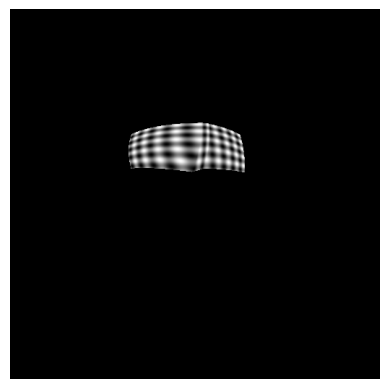

In [36]:
plt.imshow(((renders_gt[-1,0, :,:]).detach().cpu()))
plt.axis('off')

# plt.savefig("et.png", bbox_inches='tight', pad_inches = 0)


# Dataset Generation Loop


In [37]:
init_gaze = torch.tensor([[0.0, 0.0, 1.0]], device='cuda:0')
mesh_rotate.transform_normals(init_gaze)

tensor([[-0.7076, -0.3395,  0.6198]], device='cuda:0')

In [38]:
torch.random.manual_seed(30)
mesh_trans =  0.0 * cm *  torch.rand(3,device=device, dtype=dtype)
mesh_trans[0] =-0.004
mesh_trans[1] = -0.003
mesh_trans[2] =0.012
print(mesh_trans)
torch.random.manual_seed(30)
euler_angles =    -0.5 * (torch.rand(3,device=device, dtype=dtype))
euler_angles[0] =-20* np.pi/180
euler_angles[1] =  40* np.pi/180
euler_angles[2] = 0* np.pi/180
print(euler_angles * 180 /np.pi)
euler_type = "XYZ"
mesh_rotate = euler_angles_to_matrix(euler_angles, euler_type)
mesh_rotate = Rotate(R=mesh_rotate, device=device)

tensor([-0.0040, -0.0030,  0.0120], device='cuda:0')
tensor([-20.0000,  40.0000,   0.0000], device='cuda:0')


In [39]:
angles = 200
elevs = 10 * 2 *  (np.random.random(angles) - 0.5)
azims = 10 * 2 *  (np.random.random(angles) - 0.5)

mesh_trans_x = 0.003 * 2 *  (np.random.random(angles) - 0.5) 
mesh_trans_y = 0.003 * 2 *  (np.random.random(angles) - 0.5) 
mesh_trans_z =0.003 * 2 *  (np.random.random(angles) - 0.5)

In [40]:
import json

mesh_count = 5
config = {}
config["frames"] = []
dataset_dir = "./dl_data_set_12_20"
config["dataset_dir"] = dataset_dir
os.makedirs(dataset_dir, exist_ok = True)

def listify_matrix(mat):
    return np.ndarray.tolist(mat.cpu().numpy())

for i in range(angles):
    elev = elevs[i] - 15
    azim = azims[i] + 40
    torch.random.manual_seed(30)
    euler_angles =    -0.5 * (torch.rand(3,device=device, dtype=dtype))
    euler_angles[0] =elev* np.pi/180
    euler_angles[1] =  azim* np.pi/180
    euler_angles[2] = 0* np.pi/180
    euler_type = "XYZ"
    mesh_rotate = euler_angles_to_matrix(euler_angles, euler_type)
    R = Rotate(R=mesh_rotate, device=device)
    init_gaze = torch.tensor([[0.0, 0.0, 1.0]], device='cuda:0')
    real_gaze = R.transform_normals(init_gaze)
    
    torch.random.manual_seed(30)
    mesh_trans =  0.0 * cm *  torch.rand(3,device=device, dtype=dtype)
    for j in range(mesh_count):
    
        frame ={
            "elev": elev,
            "azim": azim,
            "file_path": f"./imgs/{str(i * mesh_count + j).zfill(5)}",
            "real_gaze": listify_matrix(real_gaze),
            "rot_matrix": listify_matrix( mesh_rotate),
            "mesh_trans_x":mesh_trans_x[i],
            "mesh_trans_y":mesh_trans_y[i],
            "mesh_trans_z":mesh_trans_z[i],
            "mesh_path": f"./meshes/{str(j).zfill(2)}.obj"
        }
    
        config["frames"].append(frame)
    # mesh_rotate = Rotate(R=mesh_rotate, device=device)

with open(f'{dataset_dir}/config.json', 'w') as f:
    json.dump(config, f)



In [41]:
config["frames"][18]

{'elev': -9.514664755187587,
 'azim': 35.445782479341,
 'file_path': './imgs/00018',
 'real_gaze': [[-0.5719543695449829,
   -0.16530004143714905,
   0.8034575581550598]],
 'rot_matrix': [[0.8146646618843079, 0.0, 0.5799323320388794],
  [-0.09586282819509506, 0.9862433075904846, 0.13466408848762512],
  [-0.5719543695449829, -0.16530002653598785, 0.8034575581550598]],
 'mesh_trans_x': 0.0004917424895836553,
 'mesh_trans_y': 0.001599983511501384,
 'mesh_trans_z': 0.0018410639606632028,
 'mesh_path': './meshes/03.obj'}

In [42]:


def convert_np_and_save(t, file_name):
    t_np = t.cpu().numpy().astype(np.float16)
    np.save(file_name, t_np)

for k in range(len(config["frames"])):
    
    frame = config["frames"][k]
    print(frame)
    file_path = frame["file_path"]
    
    save_dir = f"{dataset_dir}/{file_path}"
    os.makedirs(save_dir, exist_ok = True)
    elev = frame["elev"]
    azim = frame["azim"]

    torch.random.manual_seed(30)
    euler_angles =    -0.5 * (torch.rand(3,device=device, dtype=dtype))
    euler_angles[0] = elev* np.pi/180
    euler_angles[1] =  azim* np.pi/180
    euler_angles[2] = 0* np.pi/180
    euler_type = "XYZ"
    mesh_rotate = euler_angles_to_matrix(euler_angles, euler_type)
    mesh_rotate = Rotate(R=mesh_rotate, device=device)
    
    torch.random.manual_seed(30)
    mesh_trans =  0.0 * cm *  torch.rand(3,device=device, dtype=dtype)
    mesh_trans[0] = frame["mesh_trans_x"]
    mesh_trans[1] = frame["mesh_trans_y"]
    mesh_trans[2] = frame["mesh_trans_z"]
    
    obj_filename =frame["mesh_path"]
    mesh = load_objs_as_meshes([f"{dataset_dir}/{obj_filename}"], device=device)

    # model_gt = T_DM.Tianfu_MultiviewDeflectometryModel(device=device,dtype=dtype, Np=Np, init_cam=cameras,
    #                                  cameraToScreenTransform=cameraToScreenTrans,
    #                                  shader_maps=shader_maps, opt_settings=opt_settings,
    #                                   face_mesh = face_mesh,
    #                                   mesh = mesh,
    #                                   mesh_rotate = mesh_rotate,
    #                                   mesh_translate = mesh_trans,
    #                                  screen_size_u = screen_size_x ,
    #                                  screen_size_v = screen_size_y ,
    #                                  imheight = actual_imheight, 
    #                                   imwidth = actual_imwidth).to(device)

    Nt_x = 1024; # number pixels across for tecture map 
    Nt_y = 1024;
    periods = np.array([[1, 1]]); # the tensor of periods
    Nph = 4; # the number of phase shifts between [0,2*pi]
    model_gt.create_sinusoid_reflection_maps(Nt = [Nt_x, Nt_y], Nph=Nph, periods=periods);
    model_gt.pattern = model_gt.pattern
    from PIL import Image
    import skimage.transform
    import cv2
    
    tex_dir = './img_data/'
    tex_imgs = ["cross.png", "cross_2.png"]
    
    for img in tex_imgs:
        tex = imageio.imread(f"{tex_dir}/{img}")
        tex = np.asarray(tex)
        tex = skimage.transform.resize(tex, (Nt_y, Nt_x))
        tex = torch.tensor(tex, dtype= dtype, device = device)
        if len(tex.shape) == 3:
            tex = tex[:,:,:3]
        elif len(tex.shape) == 2:
            tex = tex[:,:,None].expand(-1,-1, 3)
        
        model_gt.pattern  = torch.cat((model_gt.pattern,tex.permute(2, 0,1)[None,]) )
    patterns = model_gt.pattern.clone()
    
    tex_num = 8 + len(tex_imgs)
    renders_gt = torch.zeros((tex_num,views,actual_imheight,actual_imwidth,3),device=device)
    corr = torch.zeros((views, actual_imheight,actual_imwidth,2),device=device)
    normal = torch.zeros((views, actual_imheight,actual_imwidth,3),device=device)
    dists = torch.zeros((views,100, actual_imheight,actual_imwidth),device=device)
    pixel_verts = torch.zeros((views, actual_imheight,actual_imwidth,3),device=device)

    for j in range(tex_num):
        for i in range(1):
                normal_map, corr_map, images, dist, pixel_vert= model_gt.forward(view_batchids=[i], texture_batchids=[j])
                renders_gt[j:j + 1,i:i+1,:,:,:] = images
                corr[i:i + 1,:,:,:] = corr_map
                normal[i:i + 1,:,:,:] = normal_map
                dists[i:i + 1,:,:,:] = dist
                pixel_verts[i:i + 1,:,:,:] = pixel_vert

    for j in range(tex_num):
        renders_np = renders_gt[j,0].cpu().numpy()
        renders_np = renders_np.astype(np.float16)

        renders_np = (renders_np * 225).astype(np.uint8)
        Image.fromarray(renders_np).save(f"{save_dir}/img_{j}.png")
        
    mask = (torch.abs(corr[0,:,:, 1])< 1) * (torch.abs(corr[0,:,:, 0])< 1)
    
    corr[0] = torch.where(mask[:,:,None], corr[0], np.nan * corr[0])
    convert_np_and_save(pixel_verts[0], f"{save_dir}/depth.npy")
    convert_np_and_save(corr[0], f"{save_dir}/corr.npy")
    convert_np_and_save(normal[0], f"{save_dir}/norm.npy")

    break

{'elev': -10.925424506600724, 'azim': 45.18766216833804, 'file_path': './imgs/00000', 'real_gaze': [[-0.6965605020523071, -0.189531147480011, 0.6920124888420105]], 'rot_matrix': [[0.704787015914917, 0.0, 0.7094190120697021], [-0.13445700705051422, 0.9818747043609619, 0.1335791051387787], [-0.6965605616569519, -0.18953116238117218, 0.6920125484466553]], 'mesh_trans_x': -0.002093540402072952, 'mesh_trans_y': 0.0012838905145639433, 'mesh_trans_z': 0.0006625997382791307, 'mesh_path': './meshes/00.obj'}


/tmp/ipykernel_48802/1738527454.py:60: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  tex = imageio.imread(f"{tex_dir}/{img}")


In [43]:
a = np.load("./dl_data_set_12_20/imgs/00000/norm.npy")
a.shape

(512, 512, 3)

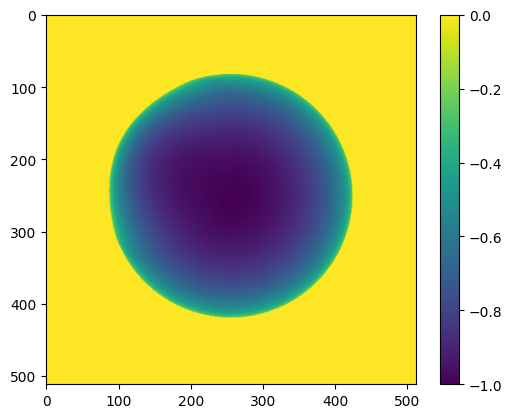

In [44]:
plt.imshow(a.astype("float")[:,:,2])
plt.colorbar()
plt.show()